## Transformer Training

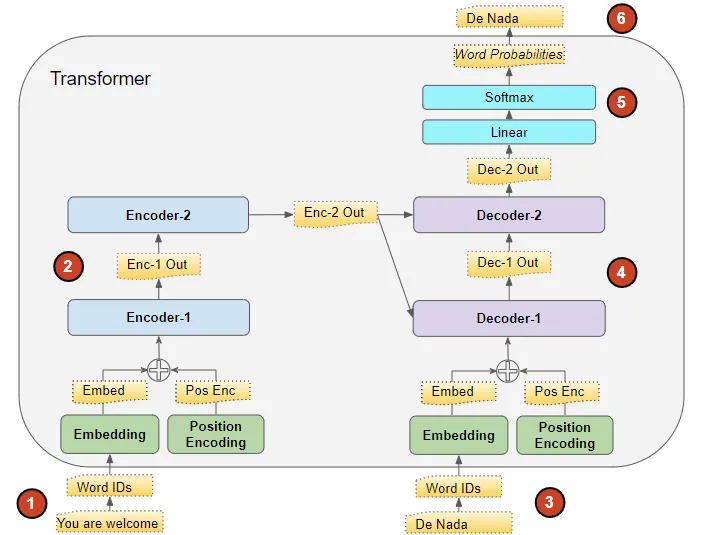


### 1. The input sequence is converted into Embeddings (with Position Encoding) and fed to the Encoder.

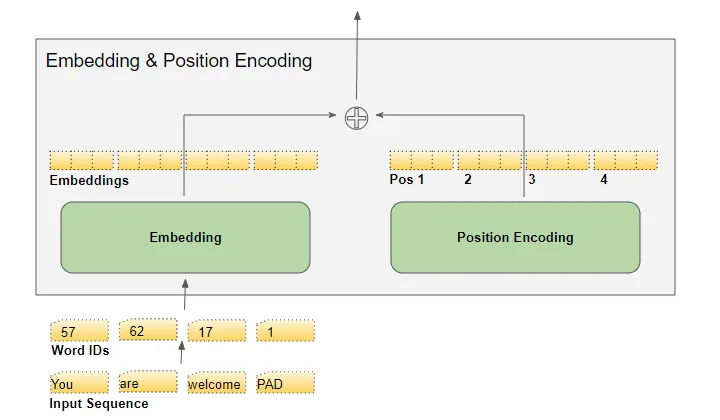

### 2. The stack of Encoders processes this and produces an encoded representation of the input sequence.

#### 2.1 Details of Encoder
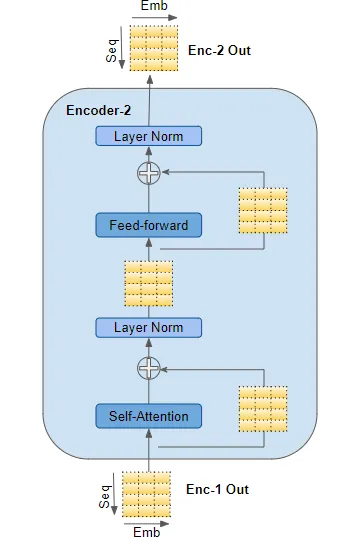

#### 2.2 Self Attention(Q,K,V)

Linear Layer(Get Q,K,and V matrics)

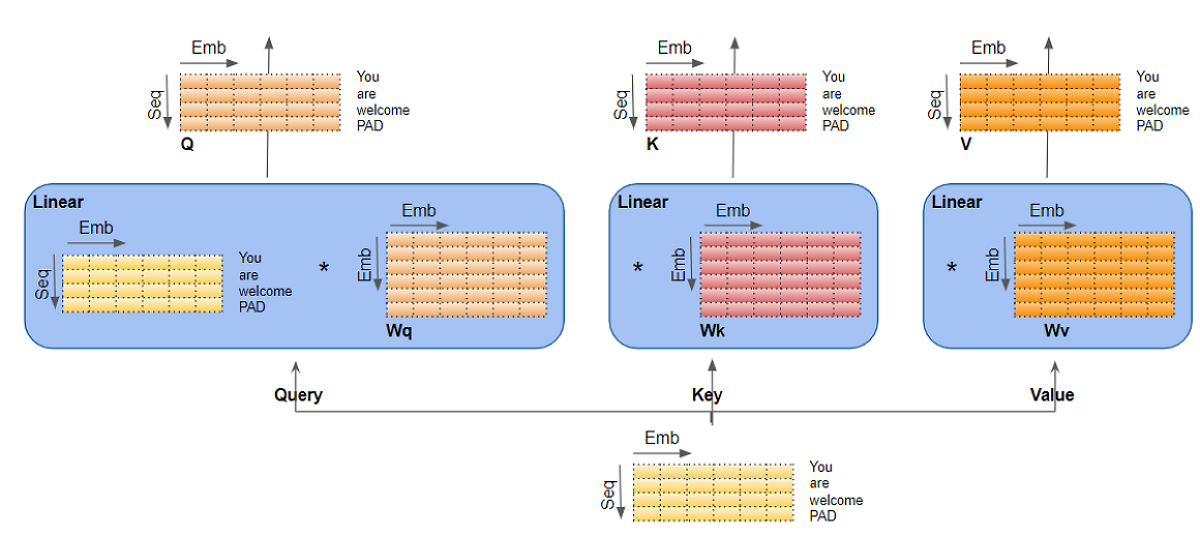

$softmax(\frac{QK^T}{\sqrt{d}})$

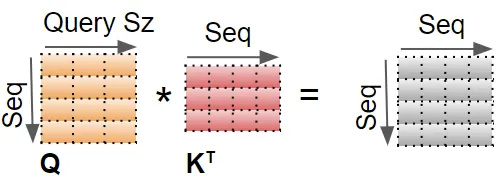

Details of Self-Attention

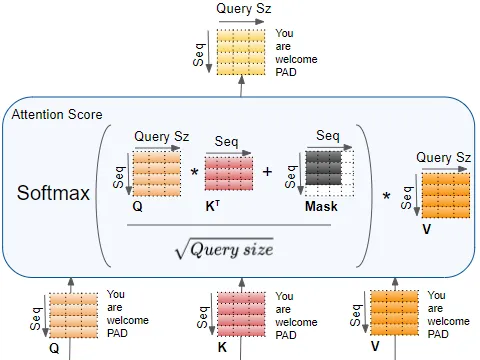

### 3. The target sequence is prepended with a start-of-sentence token, converted into Embeddings (with Position Encoding), and fed to the Decoder.
### 4. The stack of Decoders processes this along with the Encoder stack’s encoded representation to produce an encoded representation of the target sequence.

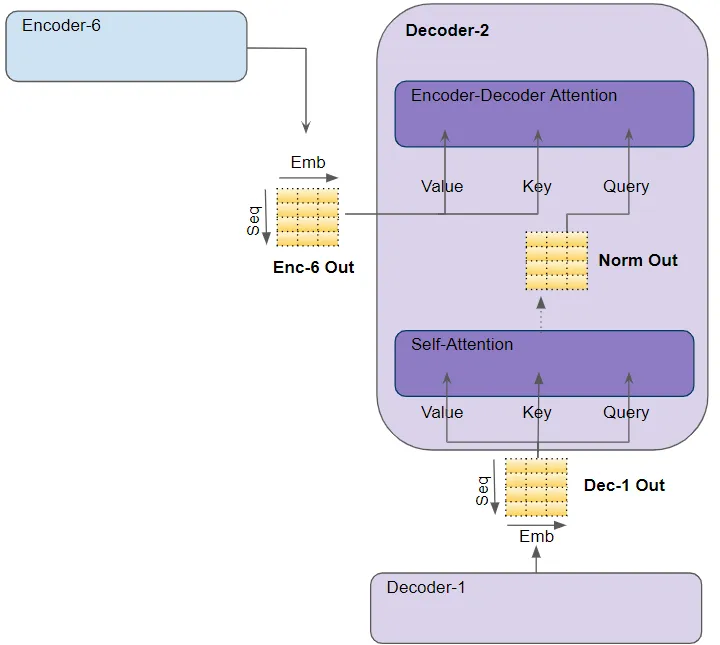

### 5. The Output layer converts it into word probabilities and the final output sequence.
### 6. The Transformer’s Loss function compares this output sequence with the target sequence from the training data. This loss is used to generate gradients to train the Transformer during back-propagation.

### Attention Mask(Training Procedures)

#### Encoder Self Attention

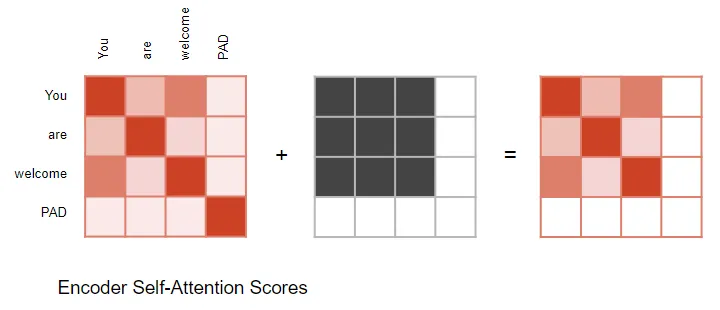

#### Encoder Decoder Attention

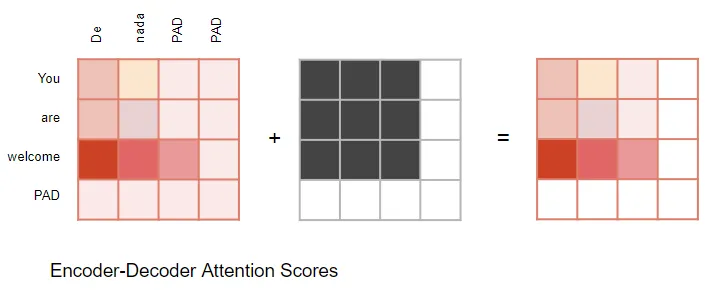

### Transformer Inference

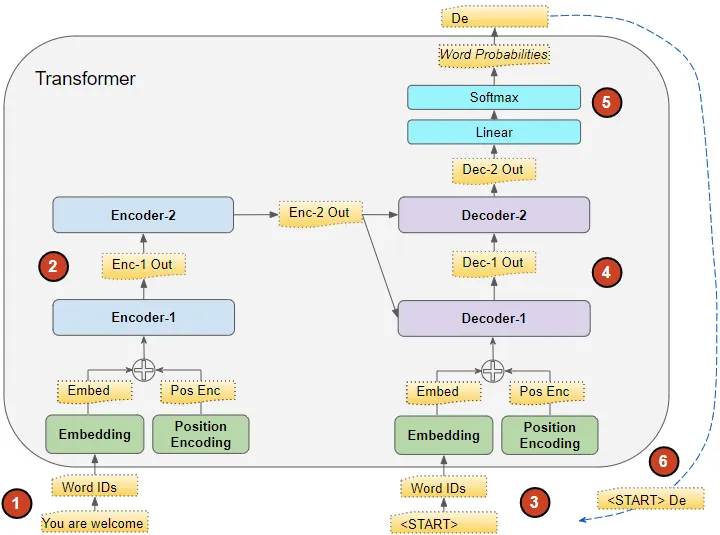

## Transformer

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
import math
import matplotlib.pyplot as plt
import numpy as np
import copy

In [2]:
# 构建Embeddings类实现文本嵌入
class Embeddings(nn.Module):
    def __init__(self, d_model, vocab):
        # d_model : 词嵌入维度
        # vocab : 词表的大小
        super(Embeddings, self).__init__()
        #定义Embedding层
        self.lut = nn.Embedding(vocab, d_model)
        self.d_model = d_model

    def forward(self, x):
        # x : 代表输入进模型的文本通过词汇映射后的数字张量，假设x的shape为(x,y)，则下面代码以后，输出形状为(x, y, d_model)
        return self.lut(x) * math.sqrt(self.d_model)

In [3]:
# 位置编码
"""位置编码器的作用，因为在Transformer的编码器结构中，并没有针对词汇位置信息的处理，因此需要在Embedding层加入
位置编码器，将词汇位置不同可能会产生不同语义的信息加入到词嵌入张量中，以弥补位置信息的缺失"""
# 定位位置编码器，同样把它看做一个层
class PostionalEncoding(nn.Module):
    def __init__(self, d_model, dropout, max_len=5000):
        # d_model: 词嵌入维度
        # dropout : 置零比率
        # max_len : 每个句子最大长度，即包含单词的个数
        # 最终输出一个加入了位置编码信息的词嵌入张量
        super(PostionalEncoding, self).__init__()
        # 实例化nn中预定义的Droupout层，并将dropout传入其中，获得对象self.droput
        self.dropout = nn.Dropout(p=dropout)
        # 初始化一个位置编码矩阵，它是一个0矩阵，它的形状是(max_len, d_model),用tensor.zeros产生
        pe = torch.zeros(max_len, d_model)
        # 初始化一个绝对位置矩阵，在我们这里，词汇的绝对位置就是用它的索引去表示
        # 所以我们首先用tensor.arange方法获得一个连续自然数向量，然后用unsqueeze拓展向量维度
        # 又因为参数传递的是1，代表矩阵拓展的位置，会使向量变成一个max_len * 1的矩阵
        position = torch.arange(0, max_len).unsqueeze(1)
        print("position:", position)
        print(position.shape)

        #绝对位置矩阵初始化后，接下来就是考虑如何将这些位置信息加入到位置编码矩阵中
        # 最简单思路就是先将max_len * 1的绝对位置矩阵position，变成max_len * d_model形状，然后覆盖原来的初始位置编码矩阵pe
        # 要做这种矩阵变换，就需要一个1 * d_model形状的变换矩阵div_term，我们对这个变换矩阵的要求是除了形状满足1*d_model之外
        # 还希望它能够将自然数的绝对位置编码缩放成足够小的数字，有助于在之后的梯度下降过程中更快收敛

        div_term = torch.exp(torch.arange(0, d_model, 2) * -(math.log(10000.0) / d_model)) #注意这里div_term是一维张量，形状是(256)
        # print(div_term)
        # print(div_term.shape)
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)

        # 这样我们就得到了位置编码矩阵pe，pe现在还只是(max_len, d_model)的二维矩阵，要想和embedding的输出（一个三维张量）进行运算
        # 就必须拓展一个维度，所以这里使用unsqueeze拓展维度
        pe = pe.unsqueeze(0) # pe.shape = (1, 5000, 512)

        # 最后把pe位置编码矩阵注册成模型的buffer
        self.register_buffer('pe', pe)

    def forward(self, x):
        # x : 文本序列的词嵌入表示，也就是Embeddings类输出的张量，是一个三维张量
        # 在positional encoding与input embedding相加之前，已经对pe做了一些适配工作，将这个三维张量的第二维也就是句子最大长度的
        # 那一维切片，与输入的x的第二维相同即x.size(1), 输入x的第二维代表什么？
        # 因为我们默认max_len为5000一般来讲是在太长了，很难有一条句子包含5000个词汇，所以要进行与输入张量的适配
        # 最后使用Variable进行封装，使其与x的样式相同，但是它是不需要进行梯度求解的，因此把requires_grad=False
        # 以下代码即完成了Figure1中PositionalEncoding与Input Embedding的相加
        x = x + Variable(self.pe[:, :x.size(1)], requires_grad = False) # pe[:, :x.size(1)]，提取所有行，提取前x.size(1)列
        return self.dropout(x)

### Encoder

In [4]:
# 掩码张量
def subsequent_mask(size):
    """生成向后遮掩的掩码张量，参数size是掩码张量最后两个维度的大小，它的最后两维形成一个方阵"""
    # 在函数中，首先定义掩码张量的形状
    attn_shape = (1, size, size)
    # 然后使用np.ones向这个形状中添加1元素，形成上三角阵，最后为了节约空间，再使其中的数据类型变为无符号8位整形unit8
    subsequent_mask = np.triu(np.ones(attn_shape, k=1).astype('uint8'))

    # 最后将numpy类型转化为torch中的tensor，内部做一个1-的操作
    # 在这个其实是做了一个三角阵的反转，subsequent_mask中的每个元素都会被1减
    # 如果是0， subsequent_mask中的该位置由0变成1
    # 如果是1，subsequent_mask中的该位置由1变成0
    return torch.from_numpy(1 - subsequent_mask)

# ============================注意力机制============================
#  注意力计算规则：它需要三个指定的输入Q(query),K(key), V(value)，然后通过公式得到注意力的计算结果
# 这个结果代表query 在key和value作用下的表示
# 学习了Q,K,V的比喻解释
# Q是一段准备被概括的文本，K是给出的提示，V是大脑中的对提示K的延伸
# 通过Q和K的相似度，来决定V中哪些部分需要被概括，哪些部分不需要

def attention(query, key, value, mask=None, dropput=None):
    """注意力机制的实现，输入分别是query, key, value, mask:掩码张量，
    dropout是nn.Dropout层的实例化对象，默认为None"""
    # 在函数中，首先取query的最后一维的大小，一般情况下等同于词嵌入维度，命名为d_k
    d_k = query.size(-1)
    # 按照注意力公式，将query与key的转置相乘，这里面key是将最后两个维度进行转置，再除以缩放系数，得到注意力得分张量scores
    scores = torch.matmul(query, key.transpose(-2, -1)) / math.sqrt(d_k)

    # 接着判断是否使用掩码张量
    if mask is not None:
        # 使用tensor的masked_fill方法，将掩码张量和scores张量每个位置一一比较，如果掩码张量处为0
        # 则对应的scores张量用-1e9这个值来替换
        scores = scores.masked_fill(mask == 0, -1e9)

    # 之后对socres的最后一维进行softmax操作，使用F.softmax方法，第一个参数是softmax对象，第二个是最后一维
    # 这样获得最终的注意力张量
    p_attn = F.softmax(scores, dim=-1)

    # 再判断是否使用dropout进行随机置0
    if dropput is not None:
        # 将p_attn传入dropout对象中进行丢弃
        p_attn = dropput(p_attn)

    # 最后根据公式将p_attn与value张量相乘获得最终的query注意力表示，同时返回注意力张量
    return torch.matmul(p_attn, value), p_attn

In [5]:
# ==============================================多头注意力机制==============================================
# 首先定义克隆函数，因为在多头注意力机制的实现中，用到多个结构相同的线性层
# 我们将使用clone函数将他们一同初始化在一个网络层列表对象中，之后的结构中也会用到该函数
def clones(module, N):
    # 用于生成相同网络层的克隆函数，它的参数module表示要克隆的目标网络层，N代表克隆数量
    # 在函数中，通过for循环对module进行N次深度拷贝，使其每个module成为独立的层
    # 然后将其放在nn.ModuleList类型的列表中存放
    return nn.ModuleList([copy.deepcopy(module) for _ in range(N)])

class MultiHeadAttention(nn.Module):
    def __init__(self, head, embedding_dim, dropout = 0.1):
        super(MultiHeadAttention, self).__init__()

        # 首先使用一个测试中常用的assert语句，判断h是否能被d_model整除
        # 这是因为我们之后要给每个头分配等量的词特征，也就是embedding_dim / head个
        assert embedding_dim % head == 0

        # 得到每个头获得的分割词向量维度
        self.d_k = embedding_dim // head
        # 传入头数h
        self.head = head
        # 然后获得线性层对象，通过nn的Linear实例化，多头注意力机制中，它的内部变换矩阵是embedding_dim * embedding_dim
        # 注意它的内部变换矩阵是方阵，目的是不改变输入张量的形状，例如,input = torch.randn(40,20),
        # m=nn.Linear(20,20), output=m(input)， 则output的形状仍然是(40,20)
        m = nn.Linear(embedding_dim, embedding_dim)
        # 将线性层m拷贝4次，为什么是4次？因为在多头注意力中，Q,K,V各需要一个，最后拼接的矩阵还需要一个
        self.linears = clones(module=m, N=4)
        # self.attn为None，它代表最后得到的注意力张量，现在还没有结果所以为None
        self.attn = None
        # 最后就是一个self.dropout对象，它通过nn中的Dropout实例化而来
        self.dropout = nn.Dropout(p=dropout)

    def forward(self, query, key, value, mask=None):
        """前向逻辑函数，它的输入参数有4个，前三个就是注意力机制需要的Q,K,V
        最后一个是注意力机制中可能需要的mask掩码张量，默认是None"""
        # 如果存在掩码张量mask
        if mask is not None:
            # 使用unsqueeze拓展维度，代表多头中的第n头
            mask = mask.unsqueeze(1)
        # 接着需要获取query形状的第一个数字，代表有多少个样本
        batch_size = query.size(0)

        """之后进入多头处理环节，首先利用zip将输入QKV与ModuleList中的前三个线性层组到一起
        然后使用for循环，将输入QKV分别传入线性层中"""
        # 执行完以下代码后，query, key, value变成了4维张量，代表多头
        query, key, value = \
        [model(x).view(batch_size, -1, self.head, self.d_k).transpose(1,2) for model, x in zip(self.linears, (query, key, value))]

        # print("多头query: ", query.size())
        # print("多头key: ", key.size())
        # print("多头value: ", value.size())

        # 得到每个头的输入后，接下来将他们传入attention中
        # 直接调用之前实现的attention函数，同时也将mask和dropout传入其中
        x, self.attn = attention(query, key, value, mask = mask, dropput=self.dropout)
        # 得到每个头的计算结果，是4维的张量，需要形状转换，
        # 前面已经将1,2两个维度进行过转置，在这里要重新转置回来
        # 注意：经历了transpose()方法后，必须要用contigous方法，不然无法使用view方法
        x = x.transpose(1, 2).contiguous().view(batch_size, -1, self.head * self.d_k)

        # 最后将x输入线性层列表中的最后一个线性层中进行处理，得到最终的多头注意力结构输出
        return self.linears[-1](x)

In [6]:
# ============================构建前馈全连接==================================
class PositionwiseFeedForward(nn.Module):
    def __init__(self, d_model, d_ff, dropout=0.1):
        # d_model: 词嵌入维度，同时也是两个线性层的输入维度与输出维度
        # d_ff：第1个线性层的输出维度与第2个线性层的输入维度
        # dropout:
        super(PositionwiseFeedForward, self).__init__()
        # 定义2层全连接的线性层
        self.w1 = nn.Linear(d_model, d_ff)
        self.w2 = nn.Linear(d_ff, d_model)
        self.dropout = nn.Dropout(p=dropout)

    def forward(self, x):
        # x: 代表来自上一层的输出
        # 首先将x送入第一个线性层网络层 x= self.w1(x)
        # 然后经历relu函数的激活，x = F.relu(x)
        # 再经历dropout层处理，x = self.dropout(x)
        # 最后送入第二个线性层 x = self.w2(x)
        return self.w2(self.dropout((F.relu(self.w1(x)))))

In [7]:
# ============================构建规范化层的类==================================
"""规范化层的作用：
它是所有深层网络模型都需要的标准网络层，因为随着网络层数的增加，通过多层的计算后参数可能开始出现过大或过小的情况，
这样可能会导致学习过程出现异常，模型可能收敛非常慢，因此都会在一定层数后接规范化层进行数值的规范化，使其特征数值在合理
的范围内"""
class LayerNorm(nn.Module):
    """初始化函数有两个参数，一个是feature，表示词嵌入的维度，另一个eps是一个足够小的数，在规范化公式的分母中出现
    防止分母为0， 默认是1e-6"""
    def __init__(self, features, eps=1e-6):
        super(LayerNorm, self).__init__()
        # 根据feature的形状初始化两个参数张量a2, 和b2，第一个初始化为1张量
        # 也就是里面的元素都是1，第二个初始化为0张量，也就是里面的元素都是0，这两个张量就是规范化层的参数
        # 因为直接对上一层得到的结果做规范化公式计算，将改变结果的正常表征，因此就需要有参数作为调节因子
        # 使其既能满足规范化要求，又能不改变针对目标的表征，最后使用nn.parameter封装，代表他们是模型的参数
        self.a2 = nn.Parameter(torch.ones(features))
        self.b2 = nn.Parameter(torch.zeros(features))

        # 把eps传到类中
        self.eps = eps

    def forward(self, x):
        """输入参数x代表上一层的输出
        在函数中，首先对输入变量x求其最后一个维度的均值，并保持输出维度与输入维度一致
        接着再求最后一个维度的标准差，然后就是根据规范化公式，用x减去均值除以标准差获得规范化的结果
        最后对结果乘以我们的缩放参数，即a2，*号代表同型点乘，即对应位置进行乘法操作，加上位移参数"""
        mean = x.mean(-1, keepdim = True)
        std = x.std(-1, keepdim = True)
        return self.a2 * (x-mean) / (std + self.eps) + self.b2

In [8]:
# ============================构建子层连接的类==================================
# 如图所示，输入到每个子层以及规范化层的过程中，还使用了残差连接，因此我们把这一部分结构整体叫做子层连接（代表子层及其连接结构）
# 在每个编码器层中，都有两个子层，这两个子层加上周围的连接结构就形成了两个子层连接结构
class SublayerConnection(nn.Module):
    def __init__(self, size, dropout = 0.1):
        """它输入参数有两个，size以及dropout, size一般是词嵌入维度
        dropout本身是对模型结构中的节点数进行随机抑制的比率
        又因为节点被抑制等效就是该节点的输出都是0，因此也可以把dropout看做是对输出矩阵的随机"""
        super(SublayerConnection, self).__init__()
        # 实例化了规范化对象self.norm
        self.norm = LayerNorm(size)
        self.dropout = nn.Dropout(p=dropout)

    def forward (self, x, sublayer):
        """前向逻辑函数中，接收上一个层或者子层的输入作为第一个参数，将该子层连接中的子层函数作为第二个参数"""
        # x: 代表上一层的输出
        # 我们首先对输出进行规范化，然后将结果传给子层处理，之后再对子层进行dropout操作
        # 随机停止一些网络中的神经元的作用，来防止过拟合，最后还有一个add操作
        return x + self.dropout(sublayer(self.norm(x))) # 先对上一层输入的x进行Norm操作，即先扔进norm层，然后再进行sublayer层，最后再相加即残差连接

In [9]:
# ============================构建编码器层==================================
class EncoderLayer(nn.Module):
    def __init__(self, size, self_attn, feed_forward, dropout):
        """它的初始化函数有4个，分别是size,其实就是词嵌入维度的大小"""
        # self_attn: 传入的多头自注意力子层的实例化对象
        # feed_forward：前馈全连接层实例化的对象
        # dropout: 置0比率
        super(EncoderLayer, self).__init__()
        self.self_attn = self_attn
        self.feed_forward = feed_forward
        # 把size传入其中
        self.size = size
        # 如图所示，编码器中有两个子层连接结构，所有用clone函数进行克隆
        self.sublayer = clones(SublayerConnection(size, dropout), 2) # 复制2个子层连接结构

    def forward(self, x, mask):
        # 首先让x经过第一个子层连接结构，内部包含多头自注意力机制子层
        # 再让张量经过第二个子层连接结构，其中包含前馈前连接网络
        x = self.sublayer[0](x, lambda x: self.self_attn(x, x, x, mask)) #自注意力机制
        return self.sublayer[1](x, self.feed_forward) # 执行feed_forward

In [10]:
# ================================构建编码器======================================
class Encoder(nn.Module):
    def __init__(self, layer, N):
        super(Encoder, self).__init__()
        self.layers = clones(layer, N) # 复制N个layer
        # 再初始化一个规范化层，它将作用在编码器的最后面
        self.norm = LayerNorm(layer.size)

    def forward(self, x, mask):
        # x: 上一层输出张量
        # mask: 掩码张量
        # 让x依次经历N个编码器层的处理，最后经过规范化层就可以输出了
        for layer in self.layers:
            x = layer(x, mask)
        return self.norm(x)

## Decoder

In [11]:
# ============================解码器层=====================================
# 解码器是由N个解码器层堆叠而成
# 每个解码器层由三个子层连接结构组成
# 第一个子层连接结构包括一个多头自注意力子层和规范化层以及一个残差连接
# 第二个子层连接结构包括一个多头注意力子层和规范化层以及一个残差连接
# 第三个子层连接结构包括一个前馈全连接子层和规范化层以及一个残差连接
# 解码器层的作用，作为解码器的组成单元，每个解码器层根据给定的输入向目标方向进行特征提取操作，即解码过程

class DecoderLayer(nn.Module):
    def __init__(self, size, self_attn, src_attn, feed_forward, dropout):
        # size : 词嵌入维度
        # self_attn : 多头自注意力对象，也就是说这个注意力机制里面，需要Q=K=V
        # src_attn : 多头注意力对象，这里Q！K=V,
        # feed_forward : 前馈前连接层对象
        super(DecoderLayer, self).__init__()
        # 在初始化函数中，主要就是将这些输入传到类中
        self.size = size
        self_attn = self_attn
        self.src_attn = src_attn
        self.feed_forward = feed_forward
        # 按照结构图，使用clones函数克隆三个子层连接对象
        self.layers = clones(SublayerConnection(size, dropout), 3)

    def forward(self, x, memory, source_mask, target_mask):
        # x: 来自上一层的输入x
        # mermory : 来自编码器层的语义存储变量
        # source_mask : 源数据掩码张量
        # target_mask : 目标数据掩码张量
        m = memory
        """将x传入第一个子层结构，第一个子层结构的输入分别是x和self_attn函数，因为是自注意力机制,所以QKV相等，最后
        一个参数是目标数据掩码张量，这时要对目标数据进行遮掩，因此此时模型可能还没有生成任何目标数据，比如在解码器准备生成第一个字符或词汇时
        我们其实已经传入了第一个字符以便计算损失，但我们不希望在生成第一个字符时模型能利用这个信息，因此我们会将其遮掩，同样生成第二个字符或词汇时
        模型只能使用第一个字符或词汇信息，第二个字符以及之后的信息都不允许被模型使用"""
        x = self.layers[0](x, lambda x: self.src_attn(x, x, x, target_mask))
        # 接着进入第二个子层，这个子层中常规的注意力机制，q是输入x; k, v是编码层输出memory
        # 同样也传入source_mask, 但进行源数据遮掩的原因并非是抑制信息泄露，而是遮蔽掉对结果没有意义的字符而产生的注意力之
        # 依次提升模型效果和训练速度，这样就完成了第二个子层的处理
        x = self.layers[1](x, lambda x: self.src_attn(x, m, m, source_mask))
        # 最后一个子层就是前馈全连接子层，经过它的处理后就可以返回结果，这就是解码器层的结构
        return self.layers[2](x, self.feed_forward)

In [12]:
# ============================解码器=====================================
class Decoder(nn.Module):
    def __init__(self, layer, N):
        """初始化函数的参数有两个，第一个就是解码器层layer，第二个是解码器层的个数N"""
        super(Decoder, self).__init__()
        # 首先使用clones方法克隆N个layer，然后实例化一个规范化层，因为数据走过了所有的解码器层最后要做规范化处理
        # layer: 代表解码器层的对象
        # N: 代表将layer进行几层的拷贝
        self.layers = clones(layer, N)
        self.norm = LayerNorm(layer.size)

    def forward(self, x, memoroy, source_mask, target_mask):
        # x: 上一层的输出x
        # memory: 编码器的输出
        # source_mask: 源数据掩码张量
        # target_mask: 目标数据掩码张量

        for layer in self.layers:
            x = layer(x, memoroy, source_mask, target_mask)
        return self.norm(x)

### Transformer

In [13]:
# ============================输出部分实现=====================================
# 学习目标：
#   了解线性层和softmax的作用
#   掌握线性层和softmax的实现过程
# 输出部分包括
#   线性层： 其作用是通过对上一步的线性变化得到指定维度的输出，也就是转换维度的作用
#   softmax层：使最后一维的向量中的数字缩放到0-1的概率值域内，并满足他们的和为1
class Generator(nn.Module):
    def __init__(self, d_model, vocab_size):
        # d_model:词嵌入维度
        # vocab_size: 词表大小
        super(Generator, self).__init__()
        # 首先使用nn中预定义线性层进行实例化，得到一个对象self.project等待使用
        # 这个线性层有两个参数，就是初始化函数传进来的两个参数：d_model和vocab_size
        self.project = nn.Linear(d_model, vocab_size)

    def forward(self, x):
        return F.log_softmax(self.project(x), dim=-1) # 最后一个维度


# =================================Transformer模型构建==========================================
class Transformer(nn.Module):
    def __init__(self, encoder, decoder, source_embed, target_embed, generator):
        # encoder : 编码器对象
        # decoder : 解码器对象
        # source_embed : 源数据嵌入函数
        # target_embed : 目标数据嵌入函数
        # generator : 输出部分的类别生成器对象
        super(Transformer, self).__init__()
        # 将参数传入到类中
        self.encoder = encoder
        self.decoder = decoder
        self.src_embed = source_embed
        self.tgt_embed = target_embed
        self.generator = generator

    def forward(self, source, target, source_mask, target_mask):
        # 在函数中，将source, source_mask传入编码函数，得到结果后与source_mask, target, target_mask一同传给解码函数
        return self.decode(self.encode(source, source_mask), source_mask, target, target_mask)

    def encode(self, source, source_mask):
        # 先使用src_embed对source做处理，然后和source_mask一起传给self.encoder
        return self.encoder(self.src_embed(source), source_mask)

    def decode(self, memory, source_mask, target, target_mask):
        # 以memory即编码器的输出，source_mask, target, target_mask为参数
        # 使用tgt_embed对target做处理，然后和source_mask, target_mask, memory一起传给
        return self.decoder(self.tgt_embed(target), memory, source_mask, target_mask)

### Run the model

In [14]:
## 设置参数
c = copy.deepcopy
vocab_size = 1000
d_model = 512
N = 8 # 8个编码器层
mask =  Variable(torch.zeros(2,4,4))
size = d_model=512
d_ff=64
head=8
dropout = 0.2

## 设置编码器
en_attn = MultiHeadAttention(head, d_model)
en_ff = PositionwiseFeedForward(d_model, d_ff, dropout)
en_layer = EncoderLayer(size, en_attn, en_ff, dropout)
encoder = Encoder(en_layer, N)

## 设置解码器
de_attn = MultiHeadAttention(head, d_model)
src_attn = MultiHeadAttention(head, d_model) 
de_ff = PositionwiseFeedForward(d_model, d_ff, dropout)
de_layer = DecoderLayer(size,de_attn, src_attn=src_attn, feed_forward=de_ff, dropout=dropout) # 实例化解码器层
decoder = Decoder(layer=de_layer, N=N)

source_embed = nn.Embedding(vocab_size, d_model)
target_embed = nn.Embedding(vocab_size, d_model)
generator = Generator(d_model, vocab_size)

# 构建模型
model = Transformer(encoder, decoder, source_embed, target_embed, generator) #实例化一个transformer模型

source = target = Variable(torch.LongTensor([[100, 2, 421, 508], [491, 998, 1, 221]]))
source_mask = target_mask = Variable(torch.zeros(2, 4, 4))

model_result = model(source, target, source_mask, target_mask)

print(model_result)
print(model_result.shape)

tensor([[[-1.5280,  0.1111, -0.5078,  ...,  0.7435,  1.7182,  1.3319],
         [-1.1876,  0.6494,  0.5026,  ...,  1.0587,  1.4207,  1.9718],
         [-1.5502,  0.1699, -0.9261,  ..., -0.0575,  0.3207,  0.5743],
         [-1.6279,  0.6184,  0.0308,  ...,  0.8179,  0.6924,  0.6725]],

        [[-0.2454,  1.4094, -0.3378,  ...,  1.7998,  0.2182,  1.1506],
         [-0.5743,  1.9845, -0.0335,  ...,  1.6721,  0.2151,  0.5033],
         [-0.6276,  1.8072, -0.4973,  ...,  1.2581,  0.8498, -0.3614],
         [-0.0349,  1.7908,  0.4435,  ...,  1.6198,  0.9360,  0.6177]]],
       grad_fn=<AddBackward0>)
torch.Size([2, 4, 512])
